<a href="https://colab.research.google.com/github/abhishekgadde/Hands-on-Machine-learning/blob/main/Working_Classification_code_for_karate_club_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### All the required libraries networkx,matplotlib,sklearn,stellargraph,

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

In [2]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 5.6 MB/s 
     |████████████████████████████████| 482 kB 60.4 MB/s 
     |████████████████████████████████| 462 kB 53.7 MB/s 
     |████████████████████████████████| 41 kB 616 kB/s 


In [3]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

### Creating the data and checking how the dataframe is.

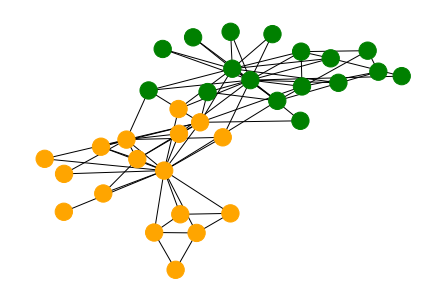

In [4]:
g_nx = nx.karate_club_graph()
cols = ["green" if g_nx.nodes[n]["club"]=='Officer' else "orange" for n in g_nx.nodes()]
nx.draw(g_nx, node_color=cols)

In [26]:
df=nx.to_pandas_edgelist(g_nx)
df

,source,target
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
73,30,32
74,30,33
75,31,32
76,31,33


### Converting data using node2veca nd stellar graph to feed into ML algorithms

In [5]:
from stellargraph import StellarGraph
from gensim.models import Word2Vec
from stellargraph.data import BiasedRandomWalk
rw = BiasedRandomWalk(StellarGraph(g_nx))
walks = rw.run(
    nodes=list(g_nx.nodes()), # root nodes
    length=100,  # maximum length of a random walk
    n=10,        # number of random walks per root node
    p=0.5,       # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0        # Defines (unormalised) probability, 1/q, for moving away from source node
    )
walks = [list(map(str, walk)) for walk in walks]
model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Constructing a StellarGraph directly from a NetworkX graph has been replaced by the `StellarGraph.from_networkx` function
  after removing the cwd from sys.path.


In [6]:
model.wv['29']

array([-0.19758627, -0.17816393, -0.07727861,  0.0491455 , -0.20101619,
        0.14824136, -0.10969786,  0.28416923,  0.05051513,  0.11744151,
        0.11343355, -0.16980894,  0.34464648, -0.11924704,  0.23264903,
       -0.30153567,  0.00732475, -0.07928434,  0.36122313, -0.03612392,
       -0.0694398 , -0.10578646,  0.06353889,  0.06314978, -0.09505843,
        0.00823236,  0.11656076, -0.08224887,  0.0750697 ,  0.12059751,
        0.14876091,  0.07159707,  0.05575386, -0.01806222,  0.08452696,
       -0.04430618, -0.0990673 , -0.08499593, -0.17804646, -0.13677904,
        0.12424523, -0.01540422, -0.11043765,  0.15508041,  0.00612439,
       -0.17160499,  0.01341983,  0.00653923, -0.02600373, -0.03275476,
        0.0752231 , -0.18829481, -0.04998505, -0.10062058, -0.11813965,
       -0.12604345,  0.20196716, -0.05688284, -0.02122798, -0.15273368,
       -0.34969208, -0.13163531,  0.07750145,  0.05812102, -0.11327811,
        0.15868042, -0.2975096 ,  0.11898443,  0.04005292,  0.44

In [7]:
node_ids = model.wv.index2word
node_ids
length=len(node_ids)

In [8]:
length

34

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


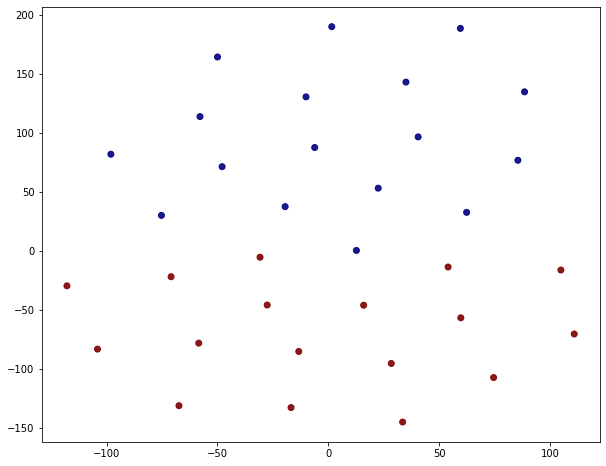

In [9]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ g_nx.nodes[int(node_id)]['club'] for node_id in node_ids]

# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)
alpha=0.9
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]
plt.figure(figsize=(10,8))
plt.scatter(node_embeddings_2d[:,0],
            node_embeddings_2d[:,1],
            c=node_colours, cmap="jet", alpha=alpha)

### Downstream task

The node embeddings calculated using `Word2Vec` can be used as feature vectors in a downstream task such as node attribute inference. 

In this example, we will use the `Node2Vec` node embeddings to train a classifier to predict the subject of a paper in Cora.

In [10]:
# X will hold the 128-dimensional input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(node_targets)

### Data Splitting

We split the data into train and test sets. 

We use 75% of the data for training and the remaining 25% for testing as a hold out test set.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, test_size=None)

In [20]:
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (6, 128)
 y_train = (6,)
 X_test = (28, 128)
 y_test = (28,)


### Classifier Training

We train a Logistic Regression classifier on the training data. 

In [21]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
classifier = log_clf.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [22]:
accuracy_score(y_test, y_pred)

0.8214285714285714

In [23]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

# Cofusion matrix 
print (confusion_matrix(y_test,y_pred))
print (classification_report(y_test,y_pred))
print (accuracy_score(y_test, y_pred))

[[10  5]
 [ 0 13]]
              precision    recall  f1-score   support

      Mr. Hi       1.00      0.67      0.80        15
     Officer       0.72      1.00      0.84        13

    accuracy                           0.82        28
   macro avg       0.86      0.83      0.82        28
weighted avg       0.87      0.82      0.82        28

0.8214285714285714


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/node2vec-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/node2vec-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>